# Stochastic bilevel model for PV investment and operational decisions

This notebook implements a stochastic bilevel model that integrates an investment decision for a photovoltaic (PV) system and associated operational decisions (grid purchase and feed-in). The code uses Julia, JuMP and Ipopt and reproduces the model described in the accompanying PDF.

In [27]:
using Pkg
Pkg.activate(".")
#Pkg.instantiate()

  Activating project at `c:\Users\nikla\git\AMOProject`


In [28]:
# Pkg.add("JuMP")
# Pkg.add("Plots")
# Pkg.add("JSON")
# Pkg.add("CPLEX")
# Pkg.add("DataFrames")

In [29]:
using JuMP, Plots, JSON, CPLEX, DataFrames

## Parameter definitions

The basic parameters are defined here, such as the number of time steps, investment costs, electricity prices and parameters for modeling PV output and emissions.

In [30]:
# Number of time periods (e.g. 12 months * 24 hours)
T = 288

# Number of scenarios per time step
num_scenarios = 5

# Investment costs (example value)
#C_inv = 10 * 12

# Social Cost of Carbon (€/t CO2)
SCC = 100

# Costs for grid procurement and revenue from feed-in (€/kWh)
c_grid_buy = 0.47
c_grid_feed = 0.083

# Emissions intensity (tCO2/kWh)
e_grid = 0.00038

# PV parameters
η_0     = 0.18    # Nominal PV efficiency
β       = 0.004   # Temperature coefficient per °C
T_ref   = 25      # Reference temperature in °C

# -- Parameters for investment cost formula according to Bergner (2019)
I0      = 1923      # €/kW
p       = 0.16      # Scaling parameter
MwSt    = 0.19      # 19% value added tax
r       = 0.0275    # Interest rate per year (2.75%)
n       = 25        # useful life in years

# -- From the annuity formula: a = r * (1+r)^n / ((1+r)^n - 1)
# We need this factor to convert the one-off investment costs
# to convert to annual costs A.
function annuity_factor(r, n)
    return r * (1+r)^n / ((1+r)^n - 1)
end
a = annuity_factor(r, n)
nothing

## Definition of the efficiency function

The `efficiency` function calculates the temperature-dependent PV efficiency.

In [31]:
function efficiency(T_t)
    return η_0 * (1 - β * (T_t - T_ref)) / 1000
end
nothing

## Load Scenario data

In [32]:
all_scenarios = JSON.parsefile("data/results/all_scenarios.json")
all_probabilities = JSON.parsefile("data/results/all_probabilities.json")

# Convert JSON arrays to Julia arrays
all_scenarios = [[convert(Array{Float64,1}, scenario) for scenario in scenarios] for scenarios in all_scenarios]
all_probabilities = [convert(Vector{Float64}, probs) for probs in all_probabilities]
println(all_scenarios[1])
println(all_probabilities[1])
nothing

[[0.0, 4.8081650263075, 0.8068817376032622], [0.0, -5.771263723091087, 1.2615778196897662], [0.0, 8.883335728643948, 0.5962195138137514], [0.0, -1.6843232198752234, 0.9976414604579212], [0.0, 1.3554820136203587, 0.9259867657899179]]
[0.272, 0.068, 0.161, 0.22, 0.279]


In [33]:
T_total = length(all_scenarios)  # 288
num_scenarios = length(all_scenarios[1])  # 5

S_t_omega = [[all_scenarios[t][ω][1] for ω in 1:num_scenarios] for t in 1:T_total]  # Solar
L_t_omega = [[all_scenarios[t][ω][3] for ω in 1:num_scenarios] for t in 1:T_total]  # Load
T_t_omega = [[all_scenarios[t][ω][2] for ω in 1:num_scenarios] for t in 1:T_total]  # Temperature

# Scenario Probabilities
Φ_t_omega = [all_probabilities[t] for t in 1:T_total]  
nothing

## Test output for the first time step

We output the values generated for the first time step (first hour in January).

In [34]:
println("First hour in January:")
println("Solar: ", S_t_omega[1])
println("Load: ", L_t_omega[1])
println("Temperature: ", T_t_omega[1])
println("Scenario probability: ", Φ_t_omega[1])

First hour in January:
Solar: [0.0, 0.0, 0.0, 0.0, 0.0]
Load: [0.8068817376032622, 1.2615778196897662, 0.5962195138137514, 0.9976414604579212, 0.9259867657899179]
Temperature: [4.8081650263075, -5.771263723091087, 8.883335728643948, -1.6843232198752234, 1.3554820136203587]
Scenario probability: [0.272, 0.068, 0.161, 0.22, 0.279]


## Creation and solution of the optimization model

The optimization model is divided into two levels:

- **Upper level:** Investment decision (variable y_PV) taking into account the annual investment costs.
- **Lower level:** Operational decisions (grid import G_in and export G_out) for each time step and each scenario. The KKT conditions of the lower level are used to transform the bilevel problem into a single-level problem.
- **Big M method:** We use the Big M method to linearize the single-level problem

The energy balance is used to ensure that consumption is covered by PV generation, grid consumption and feed-in.

In [35]:
function buildAndOptimize()
    model = Model(CPLEX.Optimizer)
    set_silent(model)

    # Upper level: investment decision (leader)
    @variable(model, 0 <= y_PV)

    # Lower level: Operational variables (Follower)<<<<<<<<<<<
    @variable(model, G_in[1:T, 1:num_scenarios] >= 0)   # Grid import
    @variable(model, G_out[1:T, 1:num_scenarios] >= 0)   # Grid export

    # Dual variables for KKT-conditions
    @variable(model, λ[1:T, 1:num_scenarios])
    @variable(model, nu_in[1:T, 1:num_scenarios] >= 0)
    @variable(model, nu_out[1:T, 1:num_scenarios] >= 0)
    @variable(model, z_in[1:T, 1:num_scenarios], Bin)
    @variable(model, z_out[1:T, 1:num_scenarios], Bin)

    # I_pv = (I0 * y_PV^(-p)) * y_PV * (1 + MwSt)
    #      = I0 * y_PV^(1-p) * (1 + MwSt)
    @expression(model, I_pv, I0 * (0.2*y_PV) * (1 + MwSt))

    # yearly investment costs via nnuity function
    @expression(model, A, I_pv * a)


    M = 1_000  # Big-M value

    for t in 1:T, ω in 1:num_scenarios
        # Calculation of PV generation as a fixed value using the efficiency function
        P_PV_val = efficiency(T_t_omega[t][ω]) * S_t_omega[t][ω]
        
        # Primal constraint: Energy balance
        @constraint(model, L_t_omega[t][ω] == y_PV * P_PV_val + G_in[t, ω] - G_out[t, ω])
        
        # Stationarity constraints (gradients of the Lagrange function)
        @constraint(model, c_grid_buy - λ[t, ω] - nu_in[t, ω] == 0)
        @constraint(model, -c_grid_feed + λ[t, ω] - nu_out[t, ω] == 0)
        
        # Big-M formulation for complementarity conditions
        @constraint(model, G_in[t, ω] <= M * z_in[t, ω])
        @constraint(model, nu_in[t, ω] <= M * (1 - z_in[t, ω]))
        @constraint(model, G_out[t, ω] <= M * z_out[t, ω])
        @constraint(model, nu_out[t, ω] <= M * (1 - z_out[t, ω]))
    end

    # Objective function: Minimization of investment costs plus weighted operating and emission costs
    @objective(model, Min,
        (A/365)*12 +
        sum(Φ_t_omega[t][ω] * (c_grid_buy * G_in[t, ω] - c_grid_feed * G_out[t, ω] + SCC * e_grid * G_in[t, ω])
            for t in 1:T, ω in 1:num_scenarios)
    )

    optimize!(model)
    return model
end

model = buildAndOptimize()
nothing

In [36]:
# Display optimal value for y_PV
println("Optimal m^2: ", value(model[:y_PV]))

# Display total cost (objective value)
total_cost = objective_value(model)
println("Total Cost: ", total_cost)
println("Total Cost Yearly: ", total_cost/12*365)

println()

# Calculate and display the breakdown of costs
# 1. Investment Cost (A) - Annualized cost
investment_cost = value(model[:A]) * 12 / 365  # Annualized investment cost
println("Investment Cost: ", investment_cost / 12 * 365)

# 2. Operation Cost (excluding SCC)
operation_cost = sum(
    value(Φ_t_omega[t][ω]) * (
        value(c_grid_buy) * value(model[:G_in][t, ω]) - value(c_grid_feed) * value(model[:G_out][t, ω])
    ) 
    for t in 1:T, ω in 1:num_scenarios
)
println("Operation Cost: ", operation_cost / 12 * 365)

# 3. SCC (Emission) Cost
scc_cost = sum(value(Φ_t_omega[t][ω]) * value(SCC) * value(e_grid) * value(model[:G_in][t, ω]) 
               for t in 1:T, ω in 1:num_scenarios)
println("SCC (Emission) Cost: ", scc_cost / 12 * 365)

Optimal m^2: 59.24935572899928
Total Cost: 115.02995372187446
Total Cost Yearly: 3498.827759040348

Investment Cost: 1514.2063985437821
Operation Cost: 1770.562501687243
SCC (Emission) Cost: 214.0588588093216


## Plotting

Compute G-in and G-out series with weighted average scenarios

In [37]:
weighted_G_out = Float64[]
weighted_G_in = Float64[]

G_out_values = [value(model[:G_out][t, ω]) for t in 1:T, ω in 1:num_scenarios]
G_out_matrix = reshape(G_out_values, T, num_scenarios)

G_in_values = [value(model[:G_in][t, ω]) for t in 1:T, ω in 1:num_scenarios]
G_in_matrix = reshape(G_in_values, T, num_scenarios)

for t in 1:T
    # Compute weighted average using scenario probabilities
    weighted_G_out_t = sum(G_out_matrix[t, ω] * Φ_t_omega[t][ω] for ω in 1:num_scenarios)
    weighted_G_in_t = sum(G_in_matrix[t, ω] * Φ_t_omega[t][ω] for ω in 1:num_scenarios)

    push!(weighted_G_out, weighted_G_out_t)
    push!(weighted_G_in, weighted_G_in_t)
end

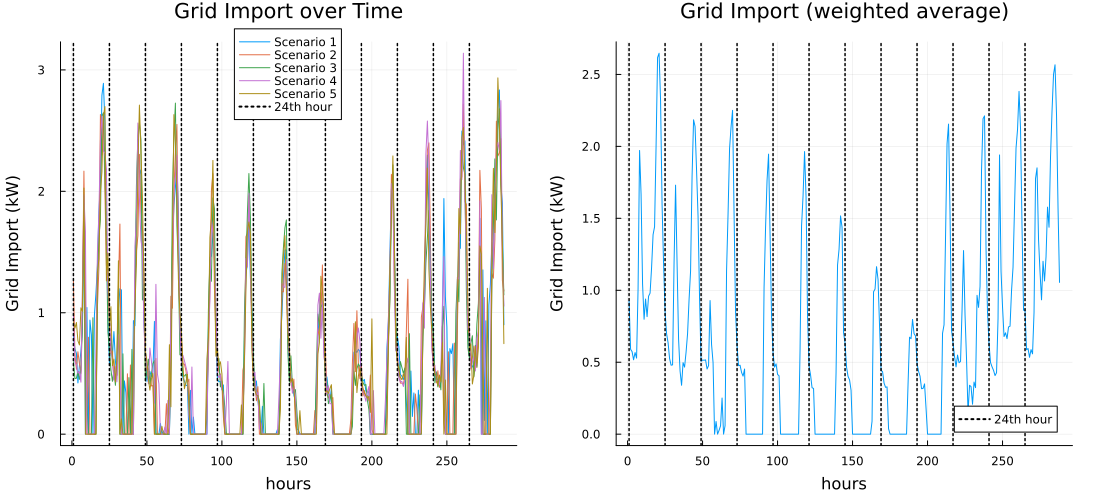

In [38]:
using Plots
using Plots.PlotMeasures

# Create the plot and assign labels to each scenario (column)
p_export = plot(1:T, G_in_matrix, xlabel="hours", ylabel="Grid Import (kW)", title="Grid Import over Time",
         label=permutedims(["Scenario $ω" for ω in 1:num_scenarios]))  # Transpose the label array

# Add vertical dotted lines every 24 steps
for i in 1:24:T
    vline!(p_export, [i], linestyle=:dot, color=:black, linewidth=1.5, label=false)  # No label for vertical lines
end
plot!(p_export, [NaN], label="24th hour", linestyle=:dot, color=:black, linewidth=2)  # Only one label
plot!(p_export, legend=(0.47, 1))
# plot most probable
p_import_average = plot(1:T, most_probable_G_in, title="Grid Import (weighted average)", label = false)
for i in 1:24:T
    vline!(p_import_average, [i], linestyle=:dot, color=:black, linewidth=1.5, label=false, xlabel="hours", ylabel="Grid Import (kW)",)  # No label for vertical lines
end
plot!(p_import_average, [NaN], label="24th hour", linestyle=:dot, color=:black, linewidth=2)  # Only one label

# Display the plot
plot(p_export, p_import_average, layout=(1, 2), size=(1100, 500), margin=5mm)

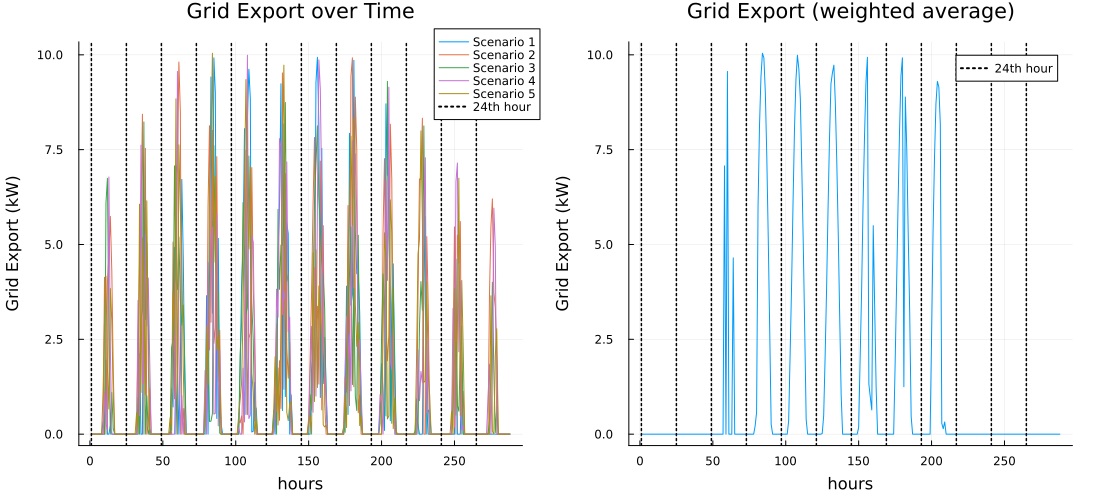

In [39]:
using Plots
using Plots.PlotMeasures

# Create the plot and assign labels to each scenario (column)
p_import = plot(1:T, G_out_matrix, xlabel="hours", ylabel="Grid Export (kW)", title="Grid Export over Time",
         label=permutedims(["Scenario $ω" for ω in 1:num_scenarios]))  # Transpose the label array

# Add vertical dotted lines every 24 steps
for i in 1:24:T
    vline!(p_import, [i], linestyle=:dot, color=:black, linewidth=1.5, label=false)  # No label for vertical lines
end
plot!(p_import, [NaN], label="24th hour", linestyle=:dot, color=:black, linewidth=2)  # Only one label
plot!(p_import, legend=(0.89, 1.0))
# plot most probable
p_export_average = plot(1:T, most_probable_G_out, title="Grid Export (weighted average)", label = false)
for i in 1:24:T
    vline!(p_export_average, [i], linestyle=:dot, color=:black, linewidth=1.5, label=false, xlabel="hours", ylabel="Grid Export (kW)",)  # No label for vertical lines
end
plot!(p_export_average, [NaN], label="24th hour", linestyle=:dot, color=:black, linewidth=2)  # Only one label

# Display the plot
plot(p_import, p_export_average, layout=(1, 2), size=(1100, 500), margin=5mm)


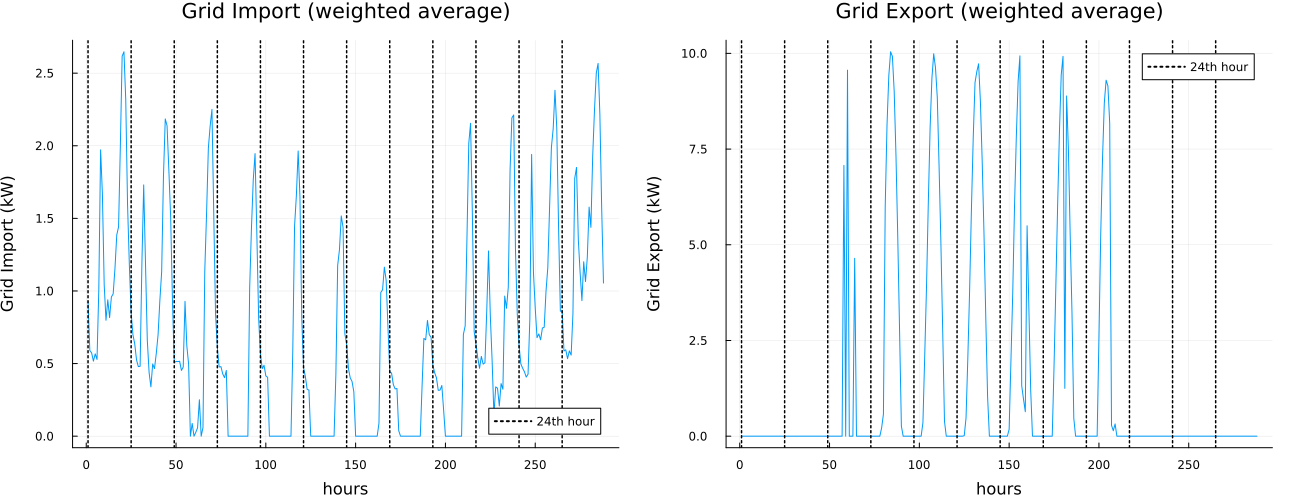

"figures\\plot_import_export_time.png"

In [40]:
plot_import_export_time = plot(p_import_average, p_export_average, layout=(1, 2), size=(1300, 500), margin=5mm)
display(plot_import_export_time)
png(plot_import_export_time, "figures/plot_import_export_time")

In [41]:
# Compute weighted averages instead of using the most probable scenario
solar_generated_weighted = [sum(value(model[:y_PV]) * efficiency(T_t_omega[t][ω]) * S_t_omega[t][ω] * Φ_t_omega[t][ω] for ω in 1:num_scenarios) for t in 1:T]
solar_exported_weighted = [sum(value(model[:G_out][t, ω]) * Φ_t_omega[t][ω] for ω in 1:num_scenarios) for t in 1:T]

# Solar used is the generated energy minus exported energy
solar_used_weighted = [solar_generated_weighted[t] - solar_exported_weighted[t] for t in 1:T]

# Convert to yearly energy (kWh)
total_solar_used_weighted = sum(solar_used_weighted) / 12 * 365
total_solar_generated_weighted = sum(solar_generated_weighted) / 12 * 365
total_solar_exported_weighted = sum(solar_exported_weighted) / 12 * 365

# Compute weighted grid import and export
sum_G_in = sum(weighted_G_in) / 12 * 365
sum_G_out = sum(weighted_G_out) / 12 * 365

# Check energy balance
println("Total Solar Generated (Weighted): ", total_solar_generated_weighted)
println("Load Served (Solar Used, Weighted): ", total_solar_used_weighted)
println("Grid Export (Weighted): ", total_solar_exported_weighted)
println("Energy Balance Check: ", total_solar_generated_weighted ≈ (total_solar_used_weighted + total_solar_exported_weighted))

Total Solar Generated (Weighted): 14374.027576319264
Load Served (Solar Used, Weighted): 3807.671020749903
Grid Export (Weighted): 10566.35655556936
Energy Balance Check: true


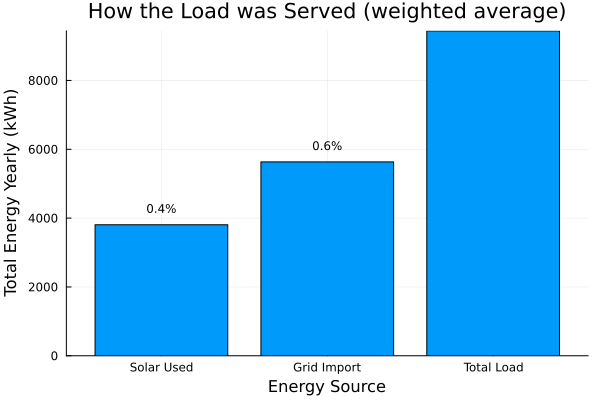

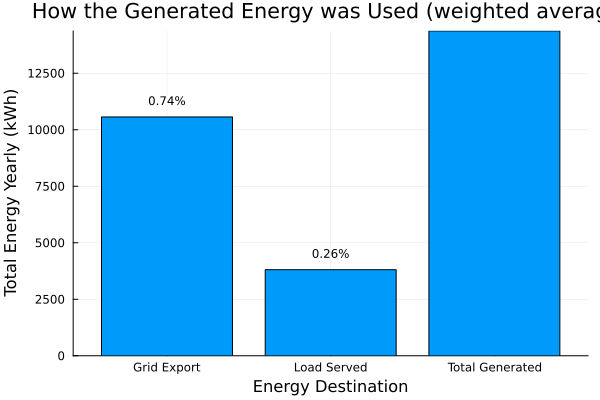

"figures\\how_generated_used.png"

In [42]:
using Plots
using DataFrames

# Create a DataFrame for Load Breakdown
load_categories = ["Solar Used", "Grid Import", "Total Load"]
load_values = [total_solar_used_weighted, sum_G_in, total_solar_used_weighted + sum_G_in]
df_load = DataFrame(group=load_categories, value=load_values)

# Plot 1: How the Load was Served
p1 = bar(df_load.group, df_load.value,
         xlabel="Energy Source",
         ylabel="Total Energy Yearly (kWh)",
         title="How the Load was Served (weighted average)",
         legend=:none,
         yformatter=:plain)

# Add percentages above each bar in the first plot
for row in eachrow(df_load[1:2, :])
    percent = row.value/ df_load.value[3]
    annotate!(p1, row.group, row.value + 0.05 * maximum(df_load.value), text("$(round(percent, digits=2))%", 8, :black, :center))
end

display(p1)
png(p1, "figures/how_load_served")

# Create a DataFrame for Solar Generation Usage
gen_categories = ["Grid Export", "Load Served", "Total Generated"]
gen_values = [total_solar_exported_weighted, total_solar_used_weighted, total_solar_generated_weighted]
df_gen = DataFrame(group=gen_categories, value=gen_values)

# Plot 2: How the Generated Energy was Used
p2 = bar(df_gen.group, df_gen.value,
         xlabel="Energy Destination",
         ylabel="Total Energy Yearly (kWh)",
         title="How the Generated Energy was Used (weighted average)",
         legend=:none,
         yformatter=:plain)

# Add percentages above each bar in the second plot
for row in eachrow(df_gen[1:2, :])
    percent = row.value/ df_gen.value[3]
    annotate!(p2, row.group, row.value + 0.05 * maximum(df_gen.value), text("$(round(percent, digits=2))%", 8, :black, :center))
end

display(p2)
png(p2, "figures/how_generated_used")

## Sensitivity Analysis

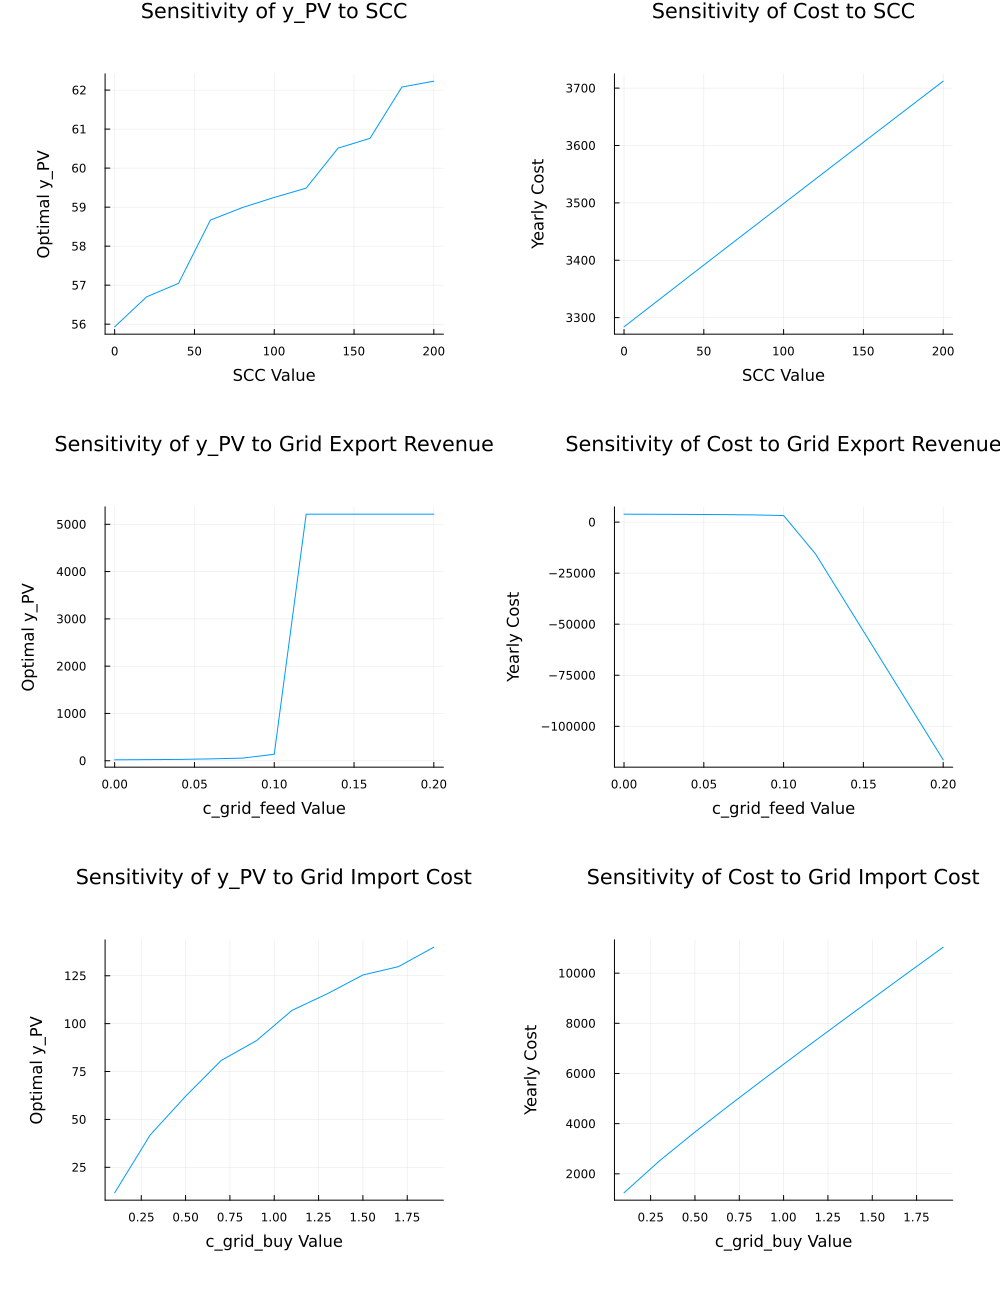

In [43]:
# Sensitivity analysis for SCC
SCC_values = 0:20:200  
y_PV_values_SCC = []
cost_SCC = []

# Loop to update SCC values and optimize the model
for SCC_value in SCC_values
    SCC = SCC_value  # Update SCC value
    
    # Re-build
    model = buildAndOptimize()
    
    # Collect the results
    push!(y_PV_values_SCC, value(model[:y_PV]))
    push!(cost_SCC, objective_value(model)/12*365)
end
SCC = 100

# Sensitivity analysis for Grid Import Cost
c_grid_buy_values = 0.1:0.2:2 
y_PV_values_grid_import = []
cost_grid_import = []

# Loop to update grid import cost and optimize the model
for c_grid_buy_value in c_grid_buy_values
    c_grid_buy = c_grid_buy_value  # Update grid import cost value
    
    # Re-build
    model = buildAndOptimize()
    
    # Collect the results
    push!(y_PV_values_grid_import, value(model[:y_PV]))
    push!(cost_grid_import, objective_value(model)/12*365)
end
c_grid_buy = 0.47

# Sensitivity analysis for Grid Export Cost
c_grid_feed_values = 0:0.02:0.2 
y_PV_values_grid_export = []
cost_grid_export = []

# Loop to update grid import cost and optimize the model
for c_grid_feed_value in c_grid_feed_values
    c_grid_feed = c_grid_feed_value  # Update grid import cost value
    
    # Re-build
    model = buildAndOptimize()
    
    # Collect the results
    push!(y_PV_values_grid_export, value(model[:y_PV]))
    push!(cost_grid_export, objective_value(model)/12*365)
end
c_grid_feed = 0.083

sens_ypv_scc = plot(SCC_values, y_PV_values_SCC, xlabel="SCC Value", ylabel="Optimal y_PV", title="Sensitivity of y_PV to SCC", label=false, legend=:topright)

sens_ypv_export = plot(c_grid_feed_values, y_PV_values_grid_export, xlabel="c_grid_feed Value", ylabel="Optimal y_PV", title="Sensitivity of y_PV to Grid Export Revenue", label=false, legend=:topright)

sens_ypv_import = plot(c_grid_buy_values, y_PV_values_grid_import, xlabel="c_grid_buy Value", ylabel="Optimal y_PV", title="Sensitivity of y_PV to Grid Import Cost", label=false, legend=:topright)

# Combine sensitivity plots for y_PV
merge1 = plot(sens_ypv_scc, sens_ypv_export, sens_ypv_import, layout=(3, 1), size=(500, 1300), margin=10mm, yformatter=:plain)
#display(merge1)

sens_cost_scc = plot(SCC_values, cost_SCC, xlabel="SCC Value", ylabel="Yearly Cost", title="Sensitivity of Cost to SCC", label=false, legend=:topright)

sens_cost_export = plot(c_grid_feed_values, cost_grid_export, xlabel="c_grid_feed Value", ylabel="Yearly Cost", title="Sensitivity of Cost to Grid Export Revenue", label=false, legend=:topright)

sens_cost_import = plot(c_grid_buy_values, cost_grid_import, xlabel="c_grid_buy Value", ylabel="Yearly Cost", title="Sensitivity of Cost to Grid Import Cost", label=false, legend=:topright)


# Combine sensitivity plots for costs
merge2 = plot(sens_cost_scc, sens_cost_export, sens_cost_import, layout=(3, 1), size=(500, 1300), margin=10mm, yformatter=:plain)
#display(merge2)

# Combine all
merge3 = plot(sens_ypv_scc, sens_cost_scc, sens_ypv_export, sens_cost_export, sens_ypv_import, sens_cost_import,
 layout=(3, 2), size=(1000, 1300), margin=10mm, yformatter=:plain)
display(merge3)
#png(merge3, "figures/sensitivity_ana")


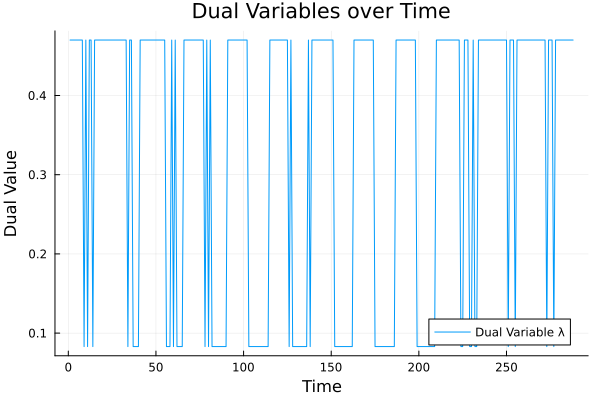

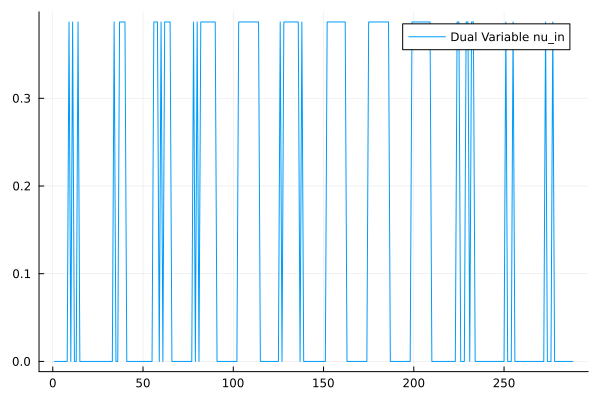

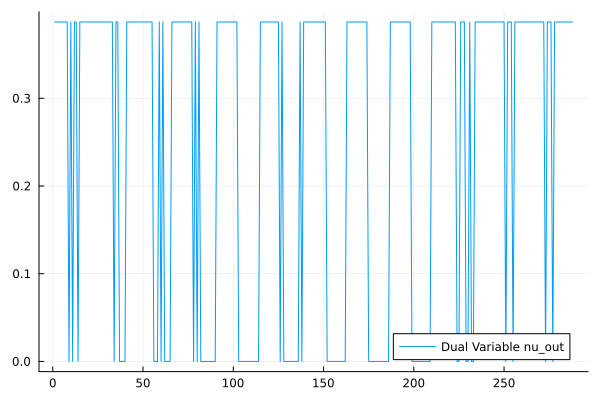

In [44]:
model = buildAndOptimize()

dual_lambda = [JuMP.value(model[:λ][t, ω]) for t in 1:T, ω in 1:1]
dual_nu_in = [JuMP.value(model[:nu_in][t, ω]) for t in 1:T, ω in 1:1]
dual_nu_out = [JuMP.value(model[:nu_out][t, ω]) for t in 1:T, ω in 1:1]

# Reshape them to match the number of time steps (T)
dual_nu_in_matrix = reshape(dual_nu_in, T, 1)
dual_nu_out_matrix = reshape(dual_nu_out, T, 1)

# Plot dual variable λ, nu_in, and nu_out
p1 = plot(1:T, dual_lambda, label="Dual Variable λ", xlabel="Time", ylabel="Dual Value", title="Dual Variables over Time")
p2 = plot(1:T, dual_nu_in_matrix, label="Dual Variable nu_in")
p3 = plot(1:T, dual_nu_out_matrix, label="Dual Variable nu_out")

# Display the plot
display(p1)
display(p2)
display(p3)